In [1]:
%reset
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Users/dimitrikrattiger/Documents/Python/Research Boulder/FEM/mesh2D.py:570: RuntimeWarning: invalid value encountered in sqrt
  r_i = (-b + np.sqrt(b**2-4*a*c))/(2*a)
/Users/dimitrikrattiger/Documents/Python/Research Boulder/FEM/mesh2D.py:570: RuntimeWarning: invalid value encountered in true_divide
  r_i = (-b + np.sqrt(b**2-4*a*c))/(2*a)


<IPython.core.display.Javascript object>


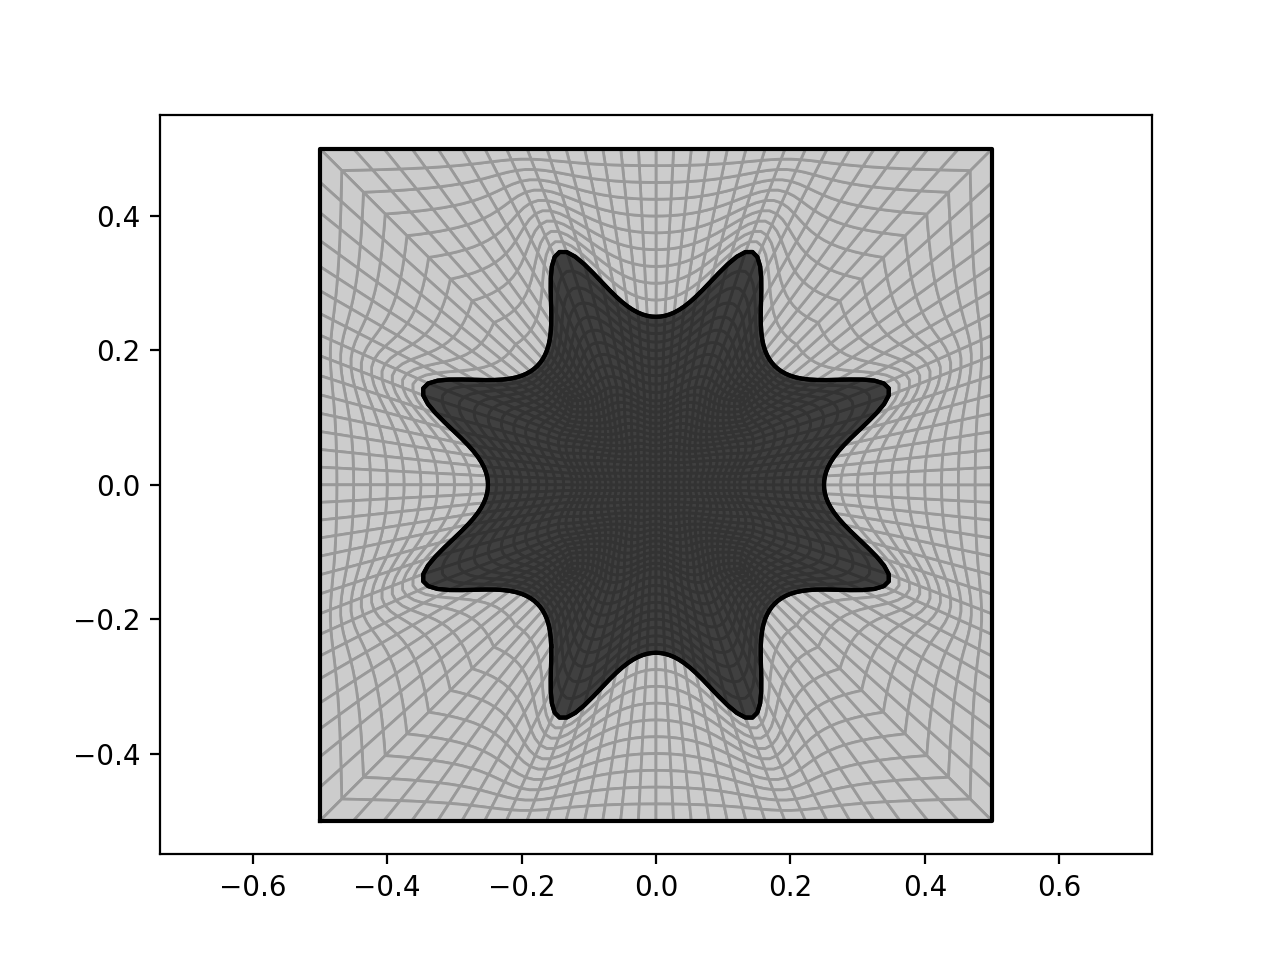

In [47]:
##### from mesh2D import mesh2DInclusion
from mesh2D import SquareWithInclusion
n = 2
mrl = 10

mesh = SquareWithInclusion(mrl,n)

#mesh = mesh2D.SquareSimple(mrl,n)

import mesh2D

fig = plt.figure(1)

meshHandles = mesh2D.plotMesh(mesh)

In [50]:
import mesh2D
import scipy.sparse.linalg
np.set_printoptions(precision=2)

# material properties
E = []
nu = []
rho = []

# aluminum properties (inclusion)
E.append(70e9)      # Young's modulus [Pa]
nu.append(0.34)     # poisson's ratio []
rho.append(2.713e3) # density [Kg/m^3]

# soft matter properties (1/8 density of Al, 1/16 elast. mod)
E.append(E[0]/16)      # Young's modulus [Pa]
nu.append(nu[0])     # poisson's ratio []
rho.append(rho[0]/8) # density [Kg/m^3]

# create list of materials
matlist = []
for i in range(len(E)):
    matlist.append(mesh2D.Material())
    matlist[i].E = E[i]
    matlist[i].nu = nu[i]
    matlist[i].rho = rho[i]
    
import time
tstart = time.time()
K,M = mesh2D.KMAssemble(mesh,matlist)

# switch to csc sparse matrix representation
K = scipy.sparse.csc_matrix(K)
M = scipy.sparse.csc_matrix(M)
tKM = time.time()-tstart

neigs = 20
tstart = time.time()
D, Phi = scipy.sparse.linalg.eigsh(K, k=neigs, M=M, sigma=1e-6)
teig = time.time()-tstart

#  normalize vecs to unit maximum displacement
for i in range(0,neigs):
    Phi[:,i] = Phi[:,i]/np.max(abs(Phi[:,i]))

isort = np.argsort(D)
D = D[isort]
Phi = Phi[:,isort]

end = time.time()
print('K,M, assembly time:',tKM,'seconds , eigenvalue solution time: ',teig,'seconds')
print('Eigenvalues: ',D)


K,M, assembly time: 8.476469039916992 , eigenvalue solution time:  4.074345111846924
Eigenvalues:  [ -1.87e-05  -5.15e-06   1.32e-06   1.10e+08   1.10e+08   1.48e+08
   1.78e+08   2.36e+08   3.40e+08   3.40e+08   3.74e+08   3.78e+08
   4.55e+08   4.55e+08   4.92e+08   5.44e+08   6.18e+08   6.18e+08
   6.20e+08   7.30e+08]


In [51]:

if True:
    nDOF = np .shape(K)[0]
    #degen_tol = 1e-6
    iKeep = [0,1,2]

    V2 = np.copy(Phi)
    V = V2[:,iKeep]
    V,dummy = np.linalg.qr(V)

    rhs = np.zeros((nDOF,3))
    rhs[0::2,0] = 1
    rhs[1::2,1] = 1
    rhs[0::2,2] = -mesh.coordinates[:,1]
    rhs[1::2,2] = mesh.coordinates[:,0]

    cvec = np.linalg.lstsq(V,rhs)[0]
    V = np.dot(V,cvec)

    Phi[:,iKeep] = V


<IPython.core.display.Javascript object>


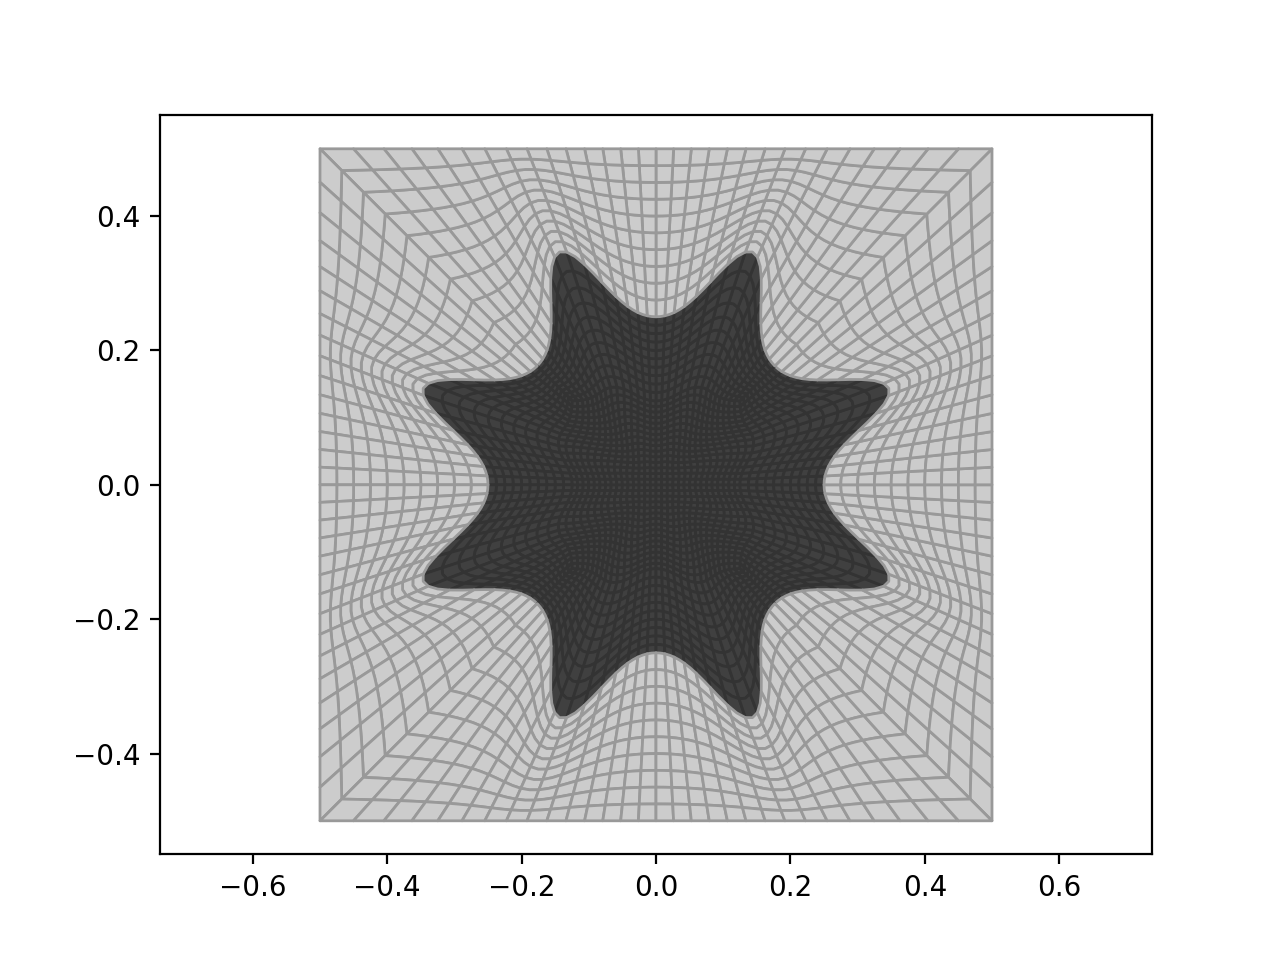

<IPython.core.display.Javascript object>


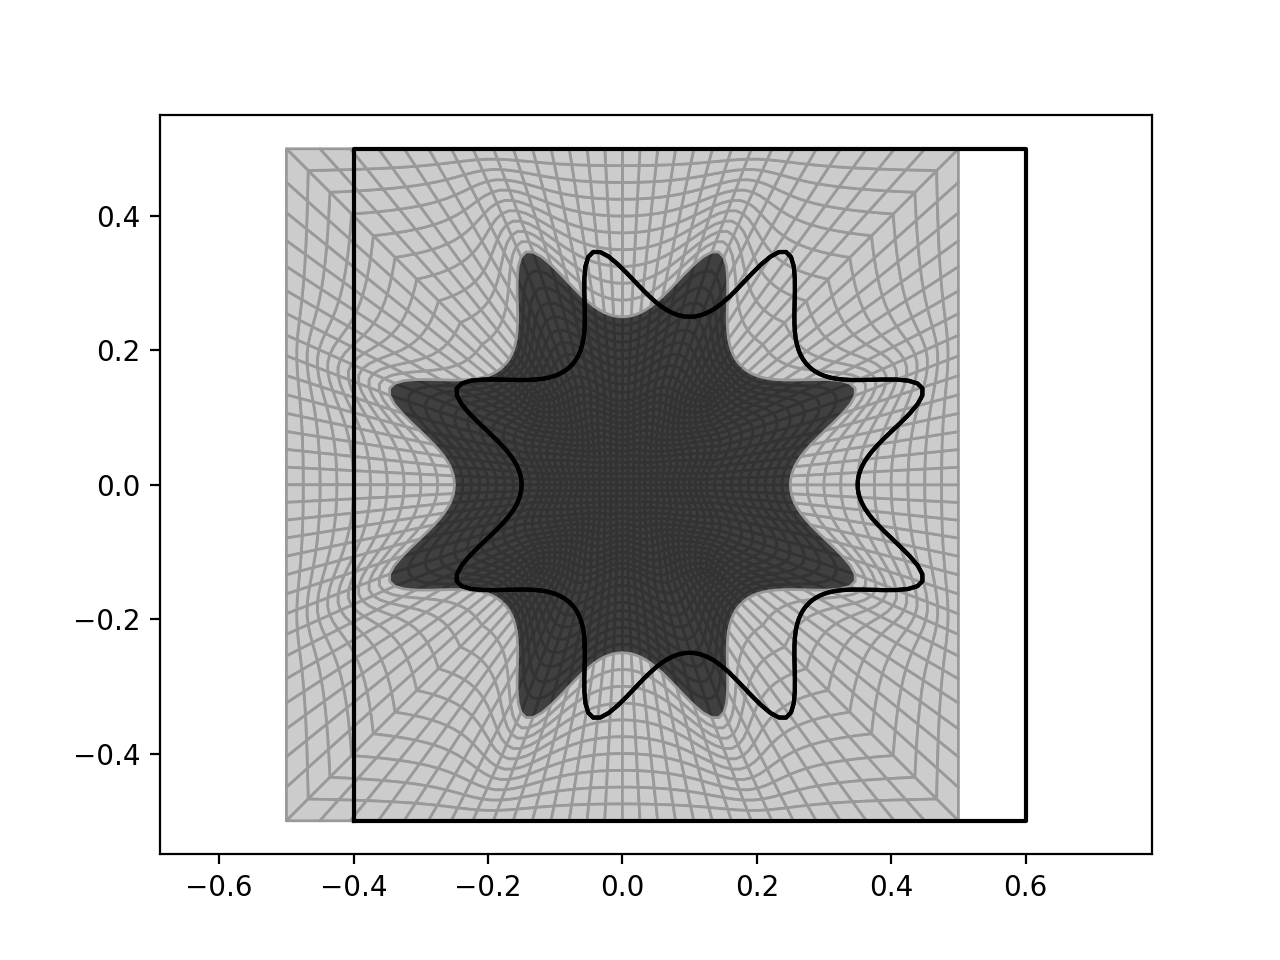

In [52]:
#ele1 = mesh2D.QuadPlaneStrain()
import math
import cmath
import copy
#from matplotlib import animation

plt.figure(250)
patchHandle = mesh2D.plotElements(mesh)

if True:
    for i in range(0,1):
        fig = plt.figure(i)
        plt.clf()
        mesh2 = copy.deepcopy(mesh)
        mesh2.coordinates = mesh2.coordinates + 0.1*np.reshape(Phi[:,i],np.shape(mesh2.coordinates))
        meshHandle = mesh2D.plotMesh(mesh2)    

plt.show()

In [40]:
from matplotlib import animation, rc
from IPython.display import HTML
if False:
    PhiPlot = Phi[:,0]
    PhiPlot = 0.2*PhiPlot/np.max(abs(PhiPlot))
    def init():
        """initialize animation"""
        patchHandle, lineHandle = mesh2D.plotMesh(mesh2)
        return patchHandle, lineHandle


    def animateMode(t):
        ax = plt.gca()

        # remove line handles
        for i in range(0,len(ax.lines)):
            ax.lines.remove(ax.lines[0])

        phase = cmath.exp(1j*t)
        disp = np.real(phase*PhiPlot)
        mesh2.coordinates = mesh.coordinates + np.reshape(disp,np.shape(mesh2.coordinates))
        animateMode.lineHandle = mesh2D.plotEdges(mesh2)

        # set axes limits so animated shape stays in the same place
        plt.xlim([-0.75,0.75])
        plt.ylim([-0.75,0.75])
        return patchHandle, animateMode.lineHandle

    patchHandle, animateMode.lineHandle = mesh2D.plotMesh(mesh2)

    nFrames = 30
    nOscillations = 1;
    oscillationRate = nOscillations*(2*math.pi)/nFrames
    tvec = np.linspace(0,2*math.pi*nOscillations,nFrames)

    #call the animator. blit=True means only re-draw the parts that have changed.
    fig = plt.figure()
    anim = animation.FuncAnimation(fig, animateMode,
                                   frames=tvec, interval=50, blit=True,
                                   init_func=init)

    #equivalent to rcParams['animation.html'] = 'html5'
    rc('animation', html='html5')

    HTML(anim.to_html5_video())

26642 'free' Degrees of freedom
Loop 1 of 49 , calculation time 8.047873735427856 seconds
Loop 2 of 49 , calculation time 7.46499490737915 seconds
Loop 3 of 49 , calculation time 7.670605659484863 seconds
Loop 4 of 49 , calculation time 7.921272039413452 seconds
Loop 5 of 49 , calculation time 7.843759298324585 seconds
Loop 6 of 49 , calculation time 8.009001970291138 seconds
Loop 7 of 49 , calculation time 8.286357879638672 seconds
Loop 8 of 49 , calculation time 7.955209970474243 seconds
Loop 9 of 49 , calculation time 7.7743659019470215 seconds
Loop 10 of 49 , calculation time 8.17792797088623 seconds
Loop 11 of 49 , calculation time 8.057186126708984 seconds
Loop 12 of 49 , calculation time 8.388150691986084 seconds
Loop 13 of 49 , calculation time 7.73645281791687 seconds
Loop 14 of 49 , calculation time 7.71761417388916 seconds
Loop 15 of 49 , calculation time 7.735853910446167 seconds
Loop 16 of 49 , calculation time 7.564242839813232 seconds
Loop 17 of 49 , calculation time 7.8

<IPython.core.display.Javascript object>


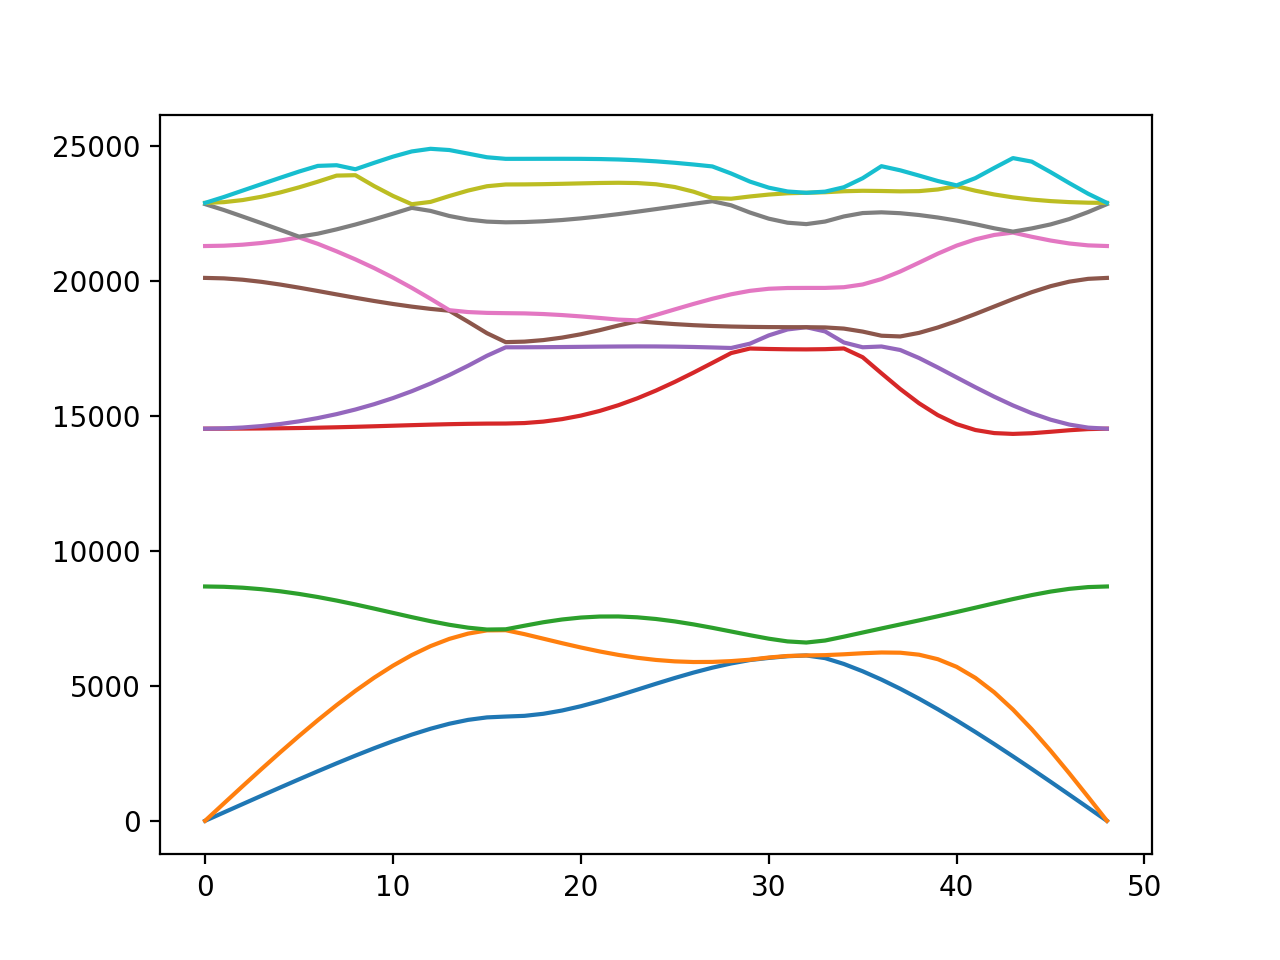

In [53]:
R = np.eye(2)

import bandStructure

#iSet = bandStructure.findNodeSets(mesh.coordinates,R)
#
#Tper = bandStructure.blochPeriodicity(mesh.coordinates,R)
GammaPt = np.array([0,0])
XPt = np.array([math.pi,0])
MPt = np.array([math.pi,math.pi])
highsym = [GammaPt,XPt,MPt,GammaPt]
kappa,kappaplot = bandStructure.waveVector(highsym,4)
w,Phi = bandStructure.dispersion_w_k(K, M, mesh.coordinates, R, kappa,10)


plt.figure(22)
plt.plot(w.T)


In [20]:
import sys
print(sys.version_info)
print(sys.maxsize)

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
9223372036854775807


In [ ]:
import cmath
print(cmath.exp(1j))


In [ ]:
"""import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
#n = np.sqrt(np.shape(emat)[1]) + 1


# fix boundaries
ifix1 = abs(0.5-abs(coords[:,0]))<1e-6
ifix2 = abs(0.5-abs(coords[:,1]))<1e-6
ifix3 = abs(np.sqrt(np.sum(coords**2,axis=1))-0.25)<1e-6
ifix = np.vstack((ifix1 | ifix2 ,ifix1 | ifix2)) | np.vstack((ifix3,ifix3))
ifix = np.reshape(ifix,(np.size(ifix),1),'F')
inotfix = np.where(np.logical_not(ifix))[0]




Kmini = np.array([[1,-1],[-1,1]])
kspring = 1
L0 = 0.1


# DOF per node
dpn = 2
    
coords2 = np.copy(coords)
n_steps = 3
for qq in range(0,n_steps):
    
    # preallocate stiffness matrix and force vectors
    #K = np.zeros((2*np.shape(coords)[0],2*np.shape(coords)[0]))
    f = np.zeros((2*np.shape(coords)[0]))
    K = lil_matrix((2*np.shape(coords)[0],2*np.shape(coords)[0]))
    
    for ii in range(0,np.shape(emat)[0]):

        emati = np.reshape(emat[ii,:],(n+1,n+1))
        for jj in range(0,n):
            for kk in range(0,n):
                quadjk = emati[jj:(jj+2),kk:(kk+2)].flatten()
                
                for mm in range(0,4):
                    for nn in range(0,4):

                        if nn>mm:

                            # global indices of nodes 1 and 2
                            i1 = quadjk[mm]
                            i2 = quadjk[nn]

                            # coordinates of nodes 1 and 2
                            x1 = coords2[i1,0]
                            y1 = coords2[i1,1]
                            x2 = coords2[i2,0]
                            y2 = coords2[i2,1]

                            # length of "spring" connecting nodes 1 and 2
                            L = np.sqrt((x2-x1)**2 + (y2-y1)**2)

                            # spring cosine and sine (for transforming stiffness to global)
                            c = (x2-x1)/L
                            s = (y2-y1)/L

                            # coordinate transformation from spring to global
                            T = np.array([[c,s,0,0],[0,0,c,s]])
                            Kspring = kspring*np.dot(
                                    np.dot(np.transpose(T),Kmini),
                                    T)

                            # if it's a diagonal spring, make it a little weaker
                            if (mm == 1 & nn == 2) | (mm == 0 & nn == 3):
                                kspring = 1#/sqrt(2)
                                #L0mult = sqrt(2)
                            else:
                                kspring = 1
                                #L0mult = 1


                            # index of DOFs associated with current spring
                            index = [2*i1,2*i1-1,2*i2]
                            index = np.concatenate((np.arange(dpn*i1,dpn*(i1+1)),
                                                   np.arange(dpn*i2,dpn*(i2+1))),
                                                   axis=0)

                            # add current spring's stiffness into master stiffness
                            K[index[:,None],index] = K[index[:,None],index] + kspring*Kspring

                            # assume initial spring length is L0 and spring is stretched into
                            # current configuration. Compute the resulting force on the nodes
                            # due to the springs.
                            #fint = (L-L0*L0mult)*kspring*np.array([[1],[-1]])
                            fint = (L*(1/n_steps))*kspring*np.array([[1],[-1]])

                            # transform to global coordinates
                            fspring = np.dot(np.transpose(T),fint)

                            # add spring's contribution to master force vector
                            f[index[:,None]] = f[index[:,None]] + fspring
    

    Kfix = K[inotfix[:,None],inotfix]
    ffix = f[inotfix]
    
    d = np.zeros(np.shape(f))
    d[inotfix] = spsolve(Kfix.tocsr(),ffix)
    d = np.reshape(d,np.shape(coords))
    coords2 = coords2 + d
    print(qq)
                        
# plot relaxed mesh 
plotmesh(coords2,emat[:,i_perim],colorvec)"""